In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### ***-: UPLODING '.csv' FILE FOR USE :-***

In [ ]:
from google.colab import files
print("Please upload your CSV file:")
uploaded = files.upload()
RFM_data = next(iter(uploaded))

Please upload your CSV file:


Saving customer_RFM_data.csv to customer_RFM_data.csv


### ***-: CHENGING '.csv' INTO DATAFRAME :-***


In [ ]:
df = pd.read_csv(RFM_data)

### ***-: BASIC DATA VARIFICATION & VALIDATION  :-***

In [ ]:
# Checking top 5 rows :-

display(df.head())

,InvoiceNo,InvoiceDate,CustomerID,Country,Quantity,UnitPrice,TotalPrice
0,INV14271,27-02-2022,12531.0,Germany,5,425.46,2127.30
1,INV11220,10-03-2023,11010.0,India,10,425.46,4254.60
2,INV10537,11-06-2022,12634.0,France,7,425.46,2978.22
3,INV12550,02-04-2023,12602.0,India,9,425.46,3829.14
4,INV15699,30-11-2022,10130.0,Germany,3,425.46,1276.38


In [ ]:
# Checking structure :-

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    8000 non-null   object 
 1   InvoiceDate  8000 non-null   object 
 2   CustomerID   7827 non-null   float64
 3   Country      8000 non-null   object 
 4   Quantity     8000 non-null   int64  
 5   UnitPrice    8000 non-null   float64
 6   TotalPrice   8000 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 437.6+ KB


In [ ]:
# Statistical summary :-

df.describe()

,CustomerID,Quantity,UnitPrice,TotalPrice
count,7827.000000,8000.000000,8.000000e+03,8000.000000
mean,11501.285806,6.019875,4.254600e+02,2561.216017
std,866.014772,4.939715,3.007205e-11,2101.650963
min,10000.000000,-2.000000,4.254600e+02,-850.920000
25%,10749.000000,2.000000,4.254600e+02,850.920000
50%,11507.000000,6.000000,4.254600e+02,2552.760000
75%,12247.000000,10.000000,4.254600e+02,4254.600000
max,12999.000000,14.000000,4.254600e+02,5956.440000


In [ ]:
# Checking missing values :-

df.isnull().sum()

,0
InvoiceNo,0
InvoiceDate,0
CustomerID,173
Country,0
Quantity,0
UnitPrice,0
TotalPrice,0


### ***-: DATA CLEANING & PREPROCESSING :-***

In [ ]:
# Remove missing CustomerID :-

df = df.dropna(subset=["CustomerID"])

In [ ]:
# Remove invalid transactions :-

df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

In [ ]:
# Check & Remove Duplicates :-

df.duplicated().sum()
df = df.drop_duplicates()

In [ ]:
# Recalculate TotalPrice :-

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [ ]:
# Convert InvoiceDate to datetime :-

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.dtypes

/tmp/ipython-input-326463080.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


,0
InvoiceNo,object
InvoiceDate,datetime64[ns]
CustomerID,float64
Country,object
Quantity,int64
UnitPrice,float64
TotalPrice,float64


In [ ]:
# Final check :-

df.describe()
df.isnull().sum()

,0
InvoiceNo,0
InvoiceDate,0
CustomerID,0
Country,0
Quantity,0
UnitPrice,0
TotalPrice,0


### ***-: DEFINE SNAPSHOT DATE :-***

In [ ]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2023-06-25 00:00:00')

### ***-: CALCULATE RFM METRICS :-***

In [ ]:
#1. RFM Calculation :-

rfm = (
    df.groupby("CustomerID")
    .agg(
        Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
        Frequency=("InvoiceNo", "nunique"),
        Monetary=("TotalPrice", "sum")
    )
    .reset_index()
)
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,10000.0,141,2,7658.28
1,10002.0,325,1,2127.30
2,10003.0,191,4,12763.80
3,10004.0,518,1,425.46
4,10005.0,454,1,2978.22


In [ ]:
#2. RFM Summary :-

rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,2647.000000,2647.000000,2647.000000,2647.000000
mean,11501.000756,183.841330,2.414809,7792.331243
std,866.739643,141.435988,1.323167,5026.366961
min,10000.000000,1.000000,1.000000,425.460000
25%,10747.500000,66.500000,1.000000,4254.600000
50%,11511.000000,151.000000,2.000000,6807.360000
75%,12254.500000,281.500000,3.000000,10636.500000
max,12999.000000,540.000000,9.000000,34887.720000


In [ ]:
# Quick Checks (Expected output: 0)

(rfm["Recency"] < 0).sum()
(rfm["Frequency"] <= 0).sum()
(rfm["Monetary"] <= 0).sum()

np.int64(0)

### ***-: RFM SCORING (Quantile-Based) :-***

In [ ]:
#1. Create R, F, M scores (1–5) :-

rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method='first'), 5, labels=[1,2,3,4,5])

In [ ]:
#2. Combine RFM Score :-

rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str)
    + rfm["F_Score"].astype(str)
    + rfm["M_Score"].astype(str)
)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,10000.0,141,2,7658.28,3,2,3,323
1,10002.0,325,1,2127.30,1,1,1,111
2,10003.0,191,4,12763.80,3,5,5,355
3,10004.0,518,1,425.46,1,1,1,111
4,10005.0,454,1,2978.22,1,1,1,111


### ***-: CUSTOMER SEGMENTATION :-***

In [ ]:
#1. Define Segments :-

def segment_customer(row):
    if row["RFM_Score"] >= "444":
        return "Champions"
    elif row["RFM_Score"] >= "344":
        return "Loyal Customers"
    elif row["RFM_Score"] >= "244":
        return "Potential Loyalists"
    elif row["RFM_Score"] >= "144":
        return "At Risk"
    else:
        return "Lost Customers"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)

In [ ]:
#2. Segment Distribution :-

rfm["Segment"].value_counts()

,count
Segment,
Champions,768
Loyal Customers,496
Lost Customers,491
Potential Loyalists,473
At Risk,419


### ***-: VISUALIZATION :-***

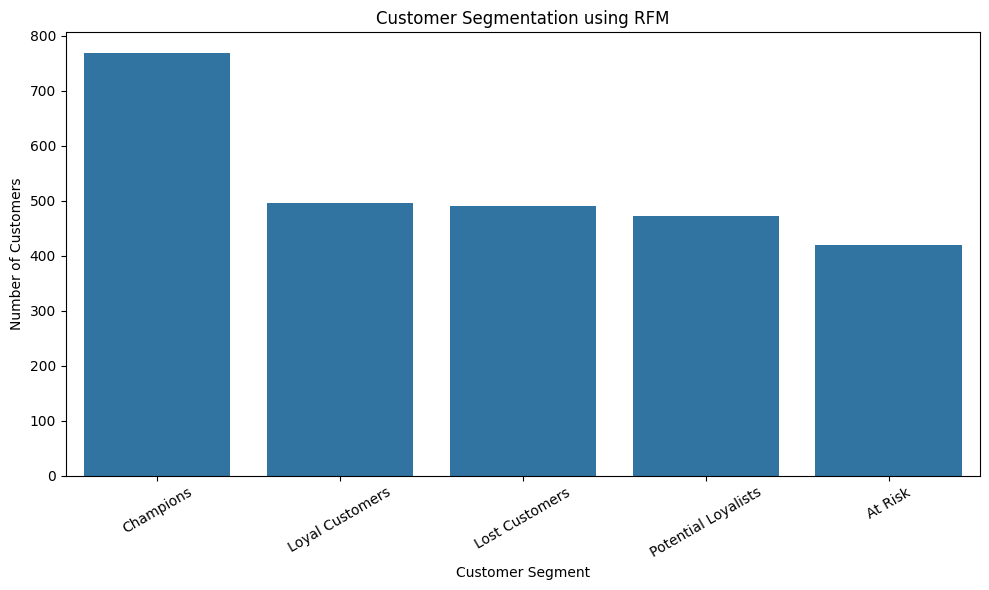

In [ ]:
#1. Customer Segment Distribution :-

plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index)
plt.title("Customer Segmentation using RFM")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

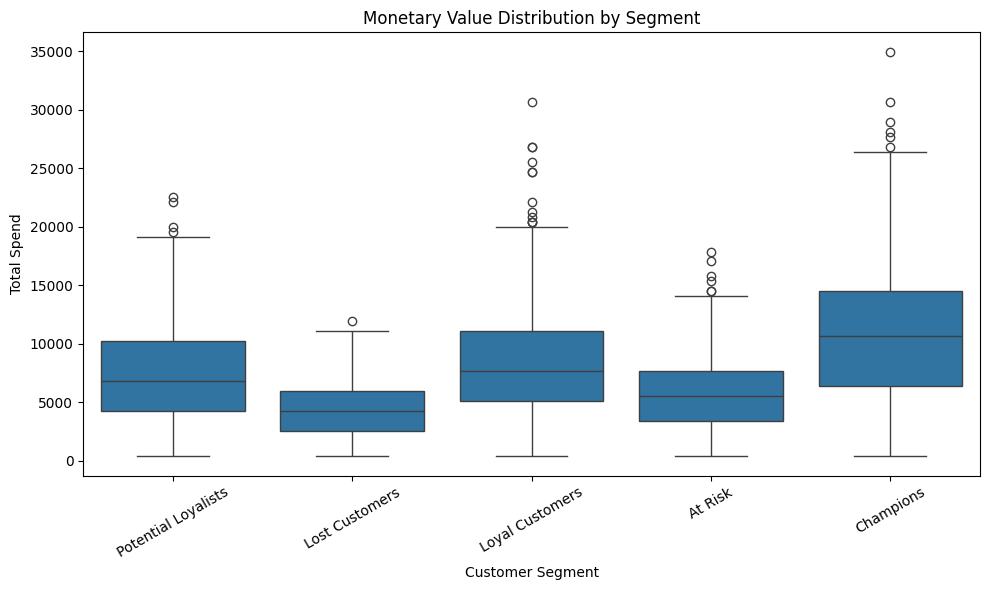

In [ ]:
#2. Monetary Value by Segment :-

plt.figure(figsize=(10,6))
sns.boxplot(data=rfm, x="Segment", y="Monetary")
plt.title("Monetary Value Distribution by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Spend")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### ***-: ADVANCED VISUALIZATION :-***

In [ ]:
#1/1. Prepare Heatmap Data :-

rfm["R_Score"] = rfm["R_Score"].astype(int)
rfm["F_Score"] = rfm["F_Score"].astype(int)
rfm["M_Score"] = rfm["M_Score"].astype(int)

rfm_pivot = (
    rfm.groupby(["R_Score", "F_Score"])["Monetary"]
    .mean()
    .reset_index()
    .pivot(index="R_Score", columns="F_Score", values="Monetary")
)

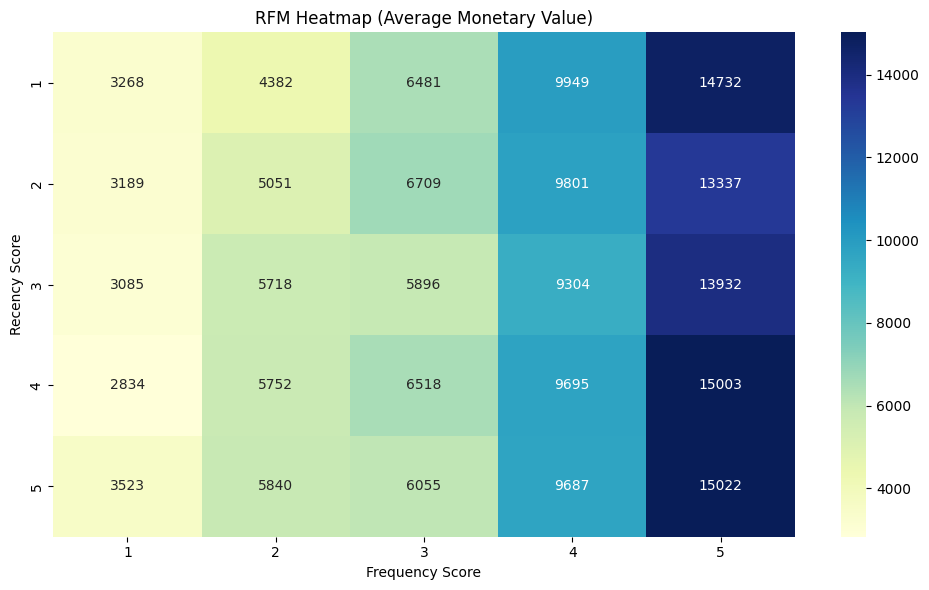

In [ ]:
#1/2. Plot Heatmap :-

plt.figure(figsize=(10,6))
sns.heatmap(
    rfm_pivot,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu"
)
plt.title("RFM Heatmap (Average Monetary Value)")
plt.xlabel("Frequency Score")
plt.ylabel("Recency Score")
plt.tight_layout()
plt.show()

In [ ]:
#2/1. Prepare 3D Scatter Plot :-

from mpl_toolkits.mplot3d import Axes3D

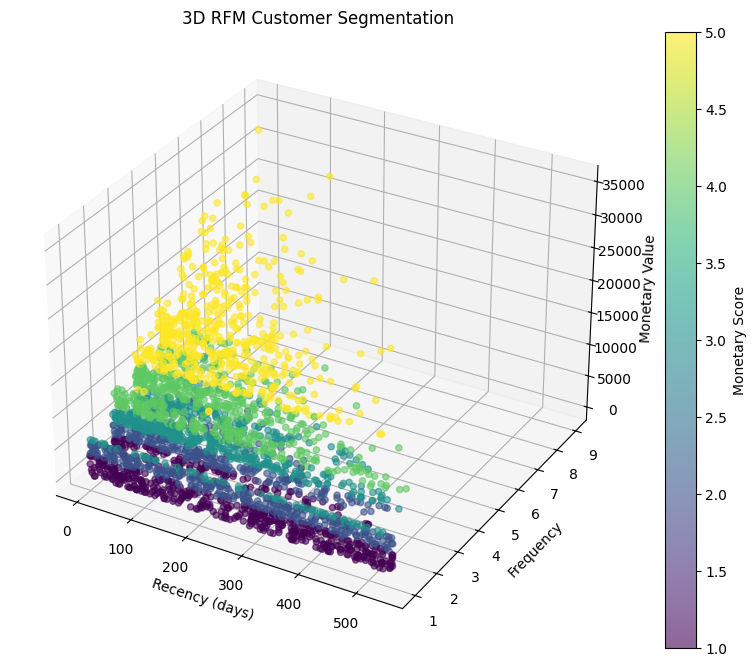

In [ ]:
#2/2. Create 3D Scatter :-

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    rfm["Recency"],
    rfm["Frequency"],
    rfm["Monetary"],
    c=rfm["M_Score"],
    cmap="viridis",
    alpha=0.6
)
ax.set_xlabel("Recency (days)")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary Value")
ax.set_title("3D RFM Customer Segmentation")
fig.colorbar(scatter, label="Monetary Score")
plt.show()

In [ ]:
#3/1. Prepare Segment-Level RFM Averages :-

segment_summary = (
    rfm.groupby("Segment")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .sort_values("Monetary", ascending=False)
)
segment_summary

,Recency,Frequency,Monetary
Segment,,,
Champions,42.480469,3.283854,10851.445937
Loyal Customers,109.522177,2.667339,8420.848427
Potential Loyalists,180.071882,2.363636,7501.768288
At Risk,261.914081,1.837709,5808.189021
Lost Customers,417.034623,1.342159,4345.584318


In [ ]:
#3/2. Prepare the data for plotting :-
segment_summary_melted = segment_summary.reset_index().melt(
    id_vars="Segment",
    value_vars=["Recency", "Frequency", "Monetary"],
    var_name="Metric",
    value_name="Average_Value"
)

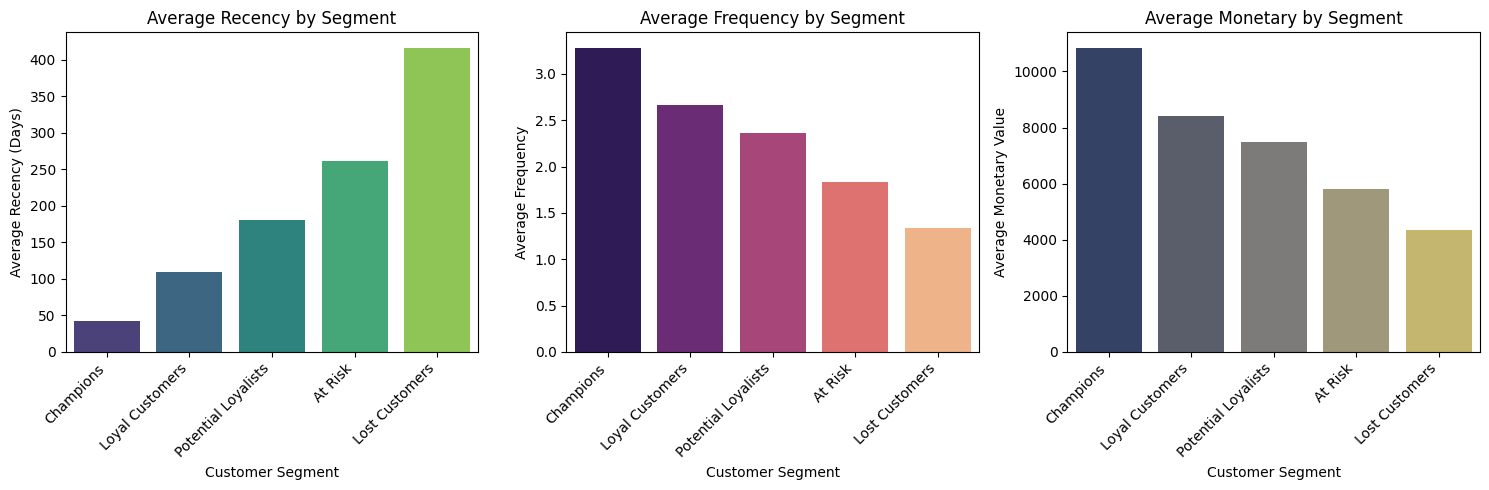

In [ ]:
#3/3. Ploting by Segment :-
plt.figure(figsize=(15, 5))


#3/3a. Plot Average Recency by Segment:-

plt.subplot(1, 3, 1)
sns.barplot(
    data=segment_summary_melted[segment_summary_melted["Metric"] == "Recency"],
    x="Segment",
    y="Average_Value",
    palette="viridis",
    hue="Segment",
    legend=False
)
plt.title("Average Recency by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Average Recency (Days)")
plt.xticks(rotation=45, ha="right")

#3/3b. Plot Average Frequency by Segment:-

plt.subplot(1, 3, 2)
sns.barplot(
    data=segment_summary_melted[segment_summary_melted["Metric"] == "Frequency"],
    x="Segment",
    y="Average_Value",
    palette="magma",
    hue="Segment",
    legend=False
)
plt.title("Average Frequency by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Average Frequency")
plt.xticks(rotation=45, ha="right")

#3/3c. Plot Average Monetary by Segment :-

plt.subplot(1, 3, 3)
sns.barplot(
    data=segment_summary_melted[segment_summary_melted["Metric"] == "Monetary"],
    x="Segment",
    y="Average_Value",
    palette="cividis",
    hue="Segment",
    legend=False
)
plt.title("Average Monetary by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Average Monetary Value")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

### ***-: FINAL RFM INSIGHTS :-***

RFM analysis successfully segmented customers based on recency, frequency,
and monetary value, revealing clear behavioral patterns across segments.

- Customers with high Recency and Frequency scores consistently generate
  the highest monetary value, confirming strong loyalty and engagement.
- A relatively small group of customers (Champions and Loyal Customers)
  contributes a disproportionate share of total revenue.
- The heatmap and 3D RFM visualization show distinct clustering of customers,
  validating the effectiveness of RFM scoring for segmentation.
- At Risk and Lost Customers represent re-engagement opportunities, while
  Champions require focused retention strategies.

These insights provide a strong foundation for designing targeted and
cost-effective marketing strategies.


### ***-: EXPORT CUSTOMER SEGMENTS :-***

In [ ]:
# Final Segmented Customer Table :-

final_customers = rfm[
    ["CustomerID", "Recency", "Frequency", "Monetary", "RFM_Score", "Segment"]
]

final_customers.head()

,CustomerID,Recency,Frequency,Monetary,RFM_Score,Segment
0,10000.0,141,2,7658.28,323,Potential Loyalists
1,10002.0,325,1,2127.30,111,Lost Customers
2,10003.0,191,4,12763.80,355,Loyal Customers
3,10004.0,518,1,425.46,111,Lost Customers
4,10005.0,454,1,2978.22,111,Lost Customers


In [ ]:
# Export to CSV :-

final_customers.to_csv(
    "rfm_customer_segments.csv",
    index=False
)

In [ ]:
# Downloading CSV :-

from google.colab import files
files.download("rfm_customer_segments.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Export Segment-wise Files :-

for segment in final_customers["Segment"].unique():
    subset = final_customers[final_customers["Segment"] == segment]
    filename = f"{segment.replace(' ', '_').lower()}_customers.csv"
    subset.to_csv(filename, index=False)
    files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>